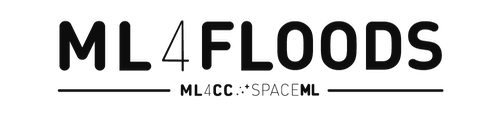

# Inference on Sentinel-2 images using a trained model

This notebook shows how to load a trained model from a experiment config file. With that model we will then make predictions on new Sentinel-2 images.

In [1]:
import sys, os
from pathlib import Path
from pyprojroot import here
# spyder up to find the root
root = here(project_files=[".here"])
# append to path
sys.path.append(str(here()))

%load_ext autoreload
%autoreload 2

## Step 1: Get config

In [11]:
from src.models.config_setup import get_default_config
experiment_name = "WFV1_unet"
checkpoint_name = "epoch=24-step=153649.ckpt"
config_fp = f"gs://ml4cc_data_lake/0_DEV/2_Mart/2_MLModelMart/{experiment_name}/config.json"
# config_fp = os.path.join(root, 'src', 'models', 'configurations', 'worldfloods_template.json')
config = get_default_config(config_fp)

# The max_tile_size param controls the max size of patches that are fed to the NN. If you're in a memory contrained environment set this value to 128
config["model_params"]["hyperparameters"]["max_tile_size"] = 1024

Loaded Config for experiment:  WFV1_unet
{   'data_params': {   'batch_size': 32,
                       'bucket_id': 'ml4floods',
                       'channel_configuration': 'all',
                       'filter_windows': False,
                       'input_folder': 'S2',
                       'loader_type': 'local',
                       'num_workers': 8,
                       'path_to_splits': '/worldfloods/public',
                       'target_folder': 'gt',
                       'test_transformation': {   'normalize': True,
                                                  'num_classes': 3,
                                                  'totensor': True},
                       'train_test_split_file': 'worldfloods/public/train_test_split.json',
                       'train_transformation': {   'normalize': True,
                                                   'num_classes': 3,
                                                   'totensor': True},
                

## Step 2: Load pre-trained model

In [3]:
from src.models.worldfloods_model import WorldFloodsModel

checkpoint_path = f"gs://ml4cc_data_lake/0_DEV/2_Mart/2_MLModelMart/{experiment_name}/checkpoint/{checkpoint_name}"
model = WorldFloodsModel.load_from_checkpoint(checkpoint_path)

model.eval()
model.to("cuda:0")

WorldFloodsModel(
  (network): UNet(
    (dconv_down1): Sequential(
      (0): Conv2d(13, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace=True)
      (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): ReLU(inplace=True)
    )
    (dconv_down2): Sequential(
      (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace=True)
      (2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): ReLU(inplace=True)
    )
    (dconv_down3): Sequential(
      (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace=True)
      (2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): ReLU(inplace=True)
    )
    (dconv_down4): Sequential(
      (0): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace=True)
      (2): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), 

In [12]:
from src.models.model_setup import get_model_inference_function

inference_function = get_model_inference_function(model, config,apply_normalization=True)

GEtting model inference function
Max tile size: 1024


## Step 3: Helper functions for plotting and reading some demo data

In [5]:
import rasterio
import numpy as np
from rasterio import plot as rasterioplt
import matplotlib.pyplot as plt
from matplotlib import colors
import matplotlib.patches as mpatches

from typing import Optional, Tuple, Union

import torch
from src.data.worldfloods.configs import BANDS_S2


@torch.no_grad()
def read_inference_pair(tiff_inputs:str, folder_ground_truth:str, 
                        window:Optional[Union[rasterio.windows.Window, Tuple[slice,slice]]], 
                        return_ground_truth: bool=False, channels:bool=None, 
                        folder_permanent_water=Optional[str]) -> Tuple[torch.Tensor, torch.Tensor, torch.Tensor, rasterio.Affine]:
    """
    Read a pair of layers from the worldfloods bucket and return them as Tensors to pass to a model, return the transform for plotting with lat/long
    
    Args:
        tiff_inputs: filename for layer in worldfloods bucket
        folder_ground_truth: folder name to be replaced by S2 in the input
        window: window of layer to use
        return_ground_truth: flag to indicate if paired gt layer should be returned
        channels: list of channels to read from the image
        return_permanent_water: Read permanent water layer raster
    
    Returns:
        (torch_inputs, torch_targets, transform): inputs Tensor, gt Tensor, transform for plotting with lat/long
    """
    
    tiff_targets = tiff_inputs.replace("/S2/", folder_ground_truth)

    with rasterio.open(tiff_inputs, "r") as rst:
        inputs = rst.read((np.array(channels) + 1).tolist(), window=window)
        # Shifted transform based on the given window (used for plotting)
        transform = rst.transform if window is None else rasterio.windows.transform(window, rst.transform)
        torch_inputs = torch.Tensor(inputs.astype(np.float32)).unsqueeze(0)
    
    if folder_permanent_water is not None:
        tiff_permanent_water = tiff_inputs.replace("/S2/", folder_permanent_water)
        with rasterio.open(tiff_permanent_water, "r") as rst:
            permanent_water = rst.read(1, window=window)  
            torch_permanent_water = torch.tensor(permanent_water)
    else:
        torch_permanent_water = torch.zeros_like(torch_inputs)
        
    if return_ground_truth:
        with rasterio.open(tiff_targets, "r") as rst:
            targets = rst.read(1, window=window)
        
        torch_targets = torch.tensor(targets).unsqueeze(0)
    else:
        torch_targets = torch.zeros_like(torch_inputs)
    
    return torch_inputs, torch_targets, torch_permanent_water, transform

COLORS_WORLDFLOODS = np.array([[0, 0, 0], # invalid
                               [139, 64, 0], # land
                               [0, 0, 139], # water
                               [220, 220, 220]], # cloud
                              dtype=np.float32) / 255

INTERPRETATION_WORLDFLOODS = ["invalid", "land", "water", "cloud"]

COLORS_WORLDFLOODS_PERMANENT = np.array([[0, 0, 0], # 0: invalid
                                         [139, 64, 0], # 1: land
                                         [237, 0, 0], # 2: flood_water
                                         [220, 220, 220], # 3: cloud
                                         [0, 0, 139], # 4: permanent_water
                                         [60, 85, 92]], # 5: seasonal_water
                                        dtype=np.float32) / 255

INTERPRETATION_WORLDFLOODS_PERMANENT = ["invalid", "land", "flood water", "cloud", "permanent water", "seasonal water"]

def gt_with_permanent_water(gt: np.ndarray, permanent_water: np.ndarray)->np.ndarray:
    """ Permanent water taken from: https://developers.google.com/earth-engine/datasets/catalog/JRC_GSW1_2_YearlyHistory"""
    gt[(gt == 2) & (permanent_water == 3)] = 4 # set as permanent_water
    gt[(gt == 2) & (permanent_water == 2)] = 5 # set as seasonal water
        
    return gt
            

def get_cmap_norm_colors(color_array, interpretation_array):
    cmap_categorical = colors.ListedColormap(color_array)
    norm_categorical = colors.Normalize(vmin=-.5,
                                        vmax=color_array.shape[0]-.5)
    patches = []
    for c, interp in zip(color_array, interpretation_array):
        patches.append(mpatches.Patch(color=c, label=interp))
    
    return cmap_categorical, norm_categorical, patches


def plot_inference_set(inputs: torch.Tensor, targets: torch.Tensor, 
                       predictions: torch.Tensor, permanent_water: torch.Tensor, transform: rasterio.Affine)->None:
    """
    Plots inputs, targets and prediction into lat/long visualisation
    
    Args:
        inputs: input Tensor
        targets: gt target Tensor
        prediction: predictions output by model (softmax, argmax already applied)
        permanent_water: permanent water raster
        transform: transform used to plot with lat/long
    """
    fig, ax = plt.subplots(2,2,figsize=(16,16))
    
    inputs_show = inputs.numpy().squeeze()
    targets_show = targets.numpy().squeeze()
    permanent_water_show = permanent_water.numpy().squeeze()
    
    targets_show = gt_with_permanent_water(targets_show, permanent_water_show)
    
    
    # Color categories {-1: invalid, 0: land, 1: water, 2: clouds}
    
    cmap_preds, norm_preds, patches_preds = get_cmap_norm_colors(COLORS_WORLDFLOODS, INTERPRETATION_WORLDFLOODS)
    cmap_gt, norm_gt, patches_gt = get_cmap_norm_colors(COLORS_WORLDFLOODS_PERMANENT, INTERPRETATION_WORLDFLOODS_PERMANENT)
    
    # +1 because value 0 is invalid
    prediction_show = np.array(prediction + 1).astype(float)

    rgb = np.clip(inputs_show[[3,2,1], :, :]/3000.,0,1)
    
    bands_false_composite = [BANDS_S2.index(b) for b in ["B11", "B8", "B4"]] # swir_1, nir, red composite
    false_rgb = np.clip(inputs_show[bands_false_composite, :, :]/3000.,0,1)
    

    rasterioplt.show(rgb,transform=transform,ax=ax[0,0])
    ax[0,0].set_title("RGB Composite")
    rasterioplt.show(false_rgb,transform=transform,ax=ax[0,1])
    ax[0,1].set_title("SWIR1,NIR,R Composite")
    rasterioplt.show(targets_show,transform=transform,ax=ax[1,0], cmap=cmap_gt, norm=norm_gt,
                     interpolation='nearest')
    rasterioplt.show(prediction_show, transform=transform, ax=ax[1,1],cmap=cmap_preds, norm=norm_preds,
                     interpolation='nearest')
    
    ax[1,0].set_title("Ground Truth")
    ax[1,0].legend(handles=patches_gt,
                 loc='upper right')
    
    ax[1,1].set_title("Model prediction")
    ax[1,1].legend(handles=patches_preds,
                   loc='upper right')
        

## Perform Inference using the inference_function

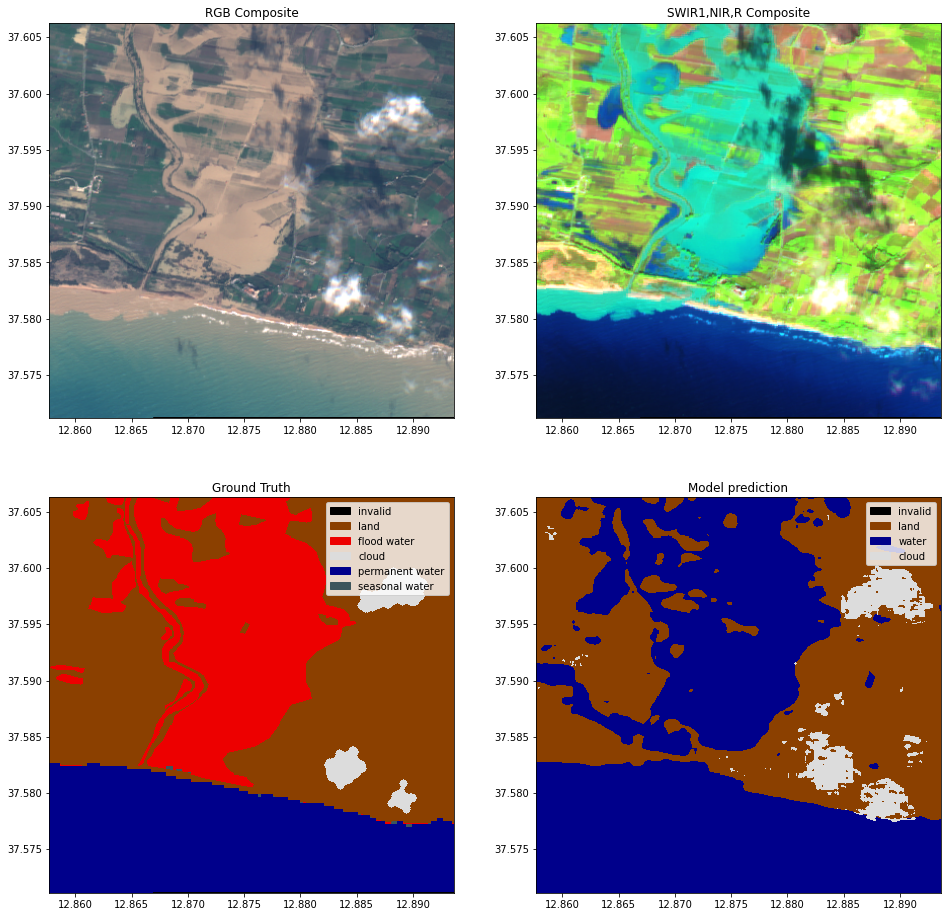

In [7]:
from src.models.model_setup import get_channel_configuration_bands

tiff_s2, window, channels = "gs://ml4floods/worldfloods/public/test/S2/EMSR333_02PORTOPALO_DEL_MONIT01_v1_observed_event_a.tif", (slice(1000,None),slice(0,400)), get_channel_configuration_bands(config.model_params.hyperparameters.channel_configuration)

# Load the image and ground truth
torch_inputs, torch_targets, torch_permanent_water, transform = read_inference_pair(tiff_s2,folder_ground_truth="/gt/", 
                                                                                    window=window, return_ground_truth=True, channels=channels,
                                                                                    folder_permanent_water="/PERMANENTWATERJRC/")

# Compute the prediction
outputs = inference_function(torch_inputs) # (batch_size, num_classes, h, w)
prediction = torch.argmax(outputs, dim=1).long() # (batch_size, h, w)
plot_inference_set(torch_inputs, torch_targets, prediction, torch_permanent_water, transform)

## Lets try another image!

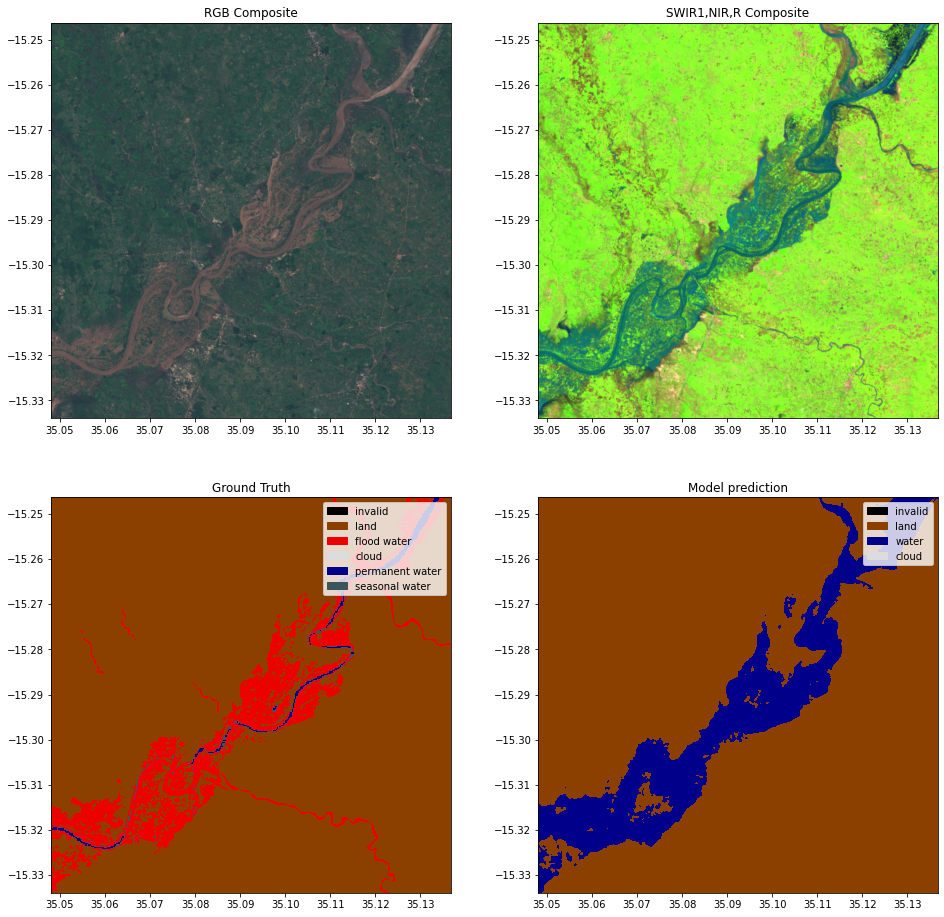

In [9]:
tiff_s2, window, channels = "gs://ml4floods/worldfloods/public/test/S2/EMSR347_07ZOMBA_DEL_v2_observed_event_a.tif", None, get_channel_configuration_bands(config.model_params.hyperparameters.channel_configuration)

torch_inputs, torch_targets, torch_permanent_water, transform = read_inference_pair(tiff_s2, folder_ground_truth="/gt/", 
                                                                                    window=window, 
                                                                                    return_ground_truth=True, channels=channels,
                                                                                    folder_permanent_water="/PERMANENTWATERJRC/")

outputs = inference_function(torch_inputs) # (batch_size, num_classes, h, w)
prediction = torch.argmax(outputs, dim=1).long() # (batch_size, h, w)
plot_inference_set(torch_inputs, torch_targets, prediction, torch_permanent_water, transform)

## Lets try another image from the new data prepared by the Janitors!

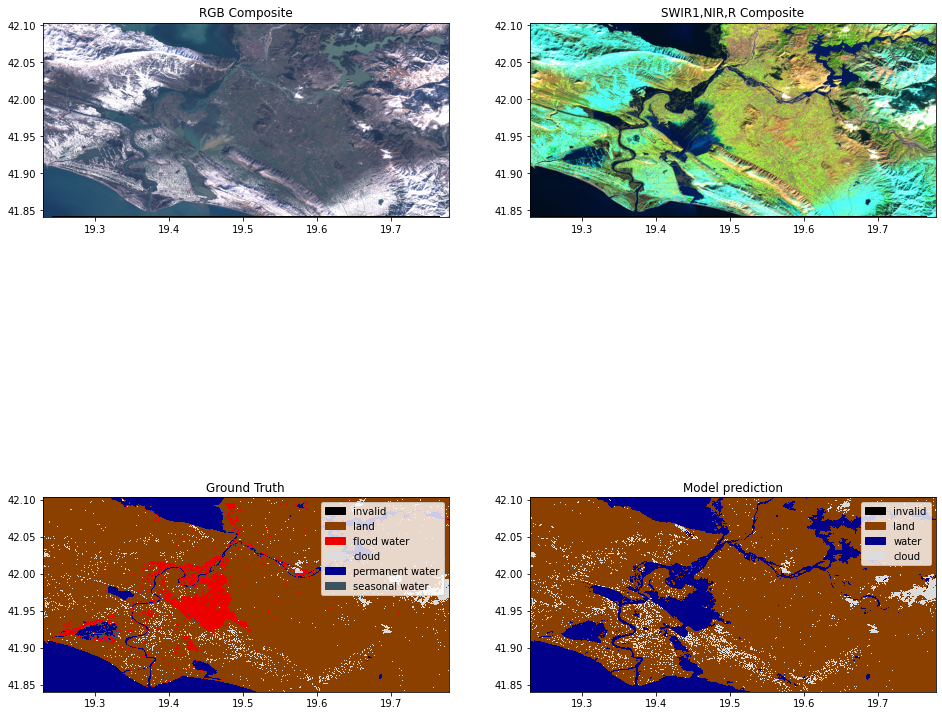

In [10]:
# 
tiff_s2, window, channels = "gs://ml4cc_data_lake/0_DEV/1_Staging/WorldFloods/S2/EMSR501/AOI01/EMSR501_AOI01_DEL_MONIT01_r1_v1.tif", None, get_channel_configuration_bands(config.model_params.hyperparameters.channel_configuration)

torch_inputs, torch_targets, torch_permanent_water, transform = read_inference_pair(tiff_s2, folder_ground_truth="/GT/V_1_1/", 
                                                                                    window=window, 
                                                                                    return_ground_truth=True, channels=channels,
                                                                                    folder_permanent_water="/JRC/")

outputs = inference_function(torch_inputs) # (batch_size, num_classes, h, w)
prediction = torch.argmax(outputs, dim=1).long() # (batch_size, h, w)
plot_inference_set(torch_inputs, torch_targets, prediction, torch_permanent_water, transform)